# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [9]:
# Enter your information here
first_and_last_name = 'Bardia Mandegar'
std_number = '401170637'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [10]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader

Check your device. We recommend using GPU. You can use GPU with google colab.

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [12]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_hat = (x - mean) / np.sqrt(var + epsilon)
    return gamma * x_hat + beta


In [13]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [14]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
half_dataset = Subset(train_set, range(0, len(train_set)//2))
train_loader_half = DataLoader(half_dataset, batch_size=64, shuffle=False, num_workers=4)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
We transform train set by RandomCrop and RandomHorizontalFlip in order to augment data and we use normaliztion as well. But on test set, we only resize and normalize to ensure that images are processed in the same way as during training.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

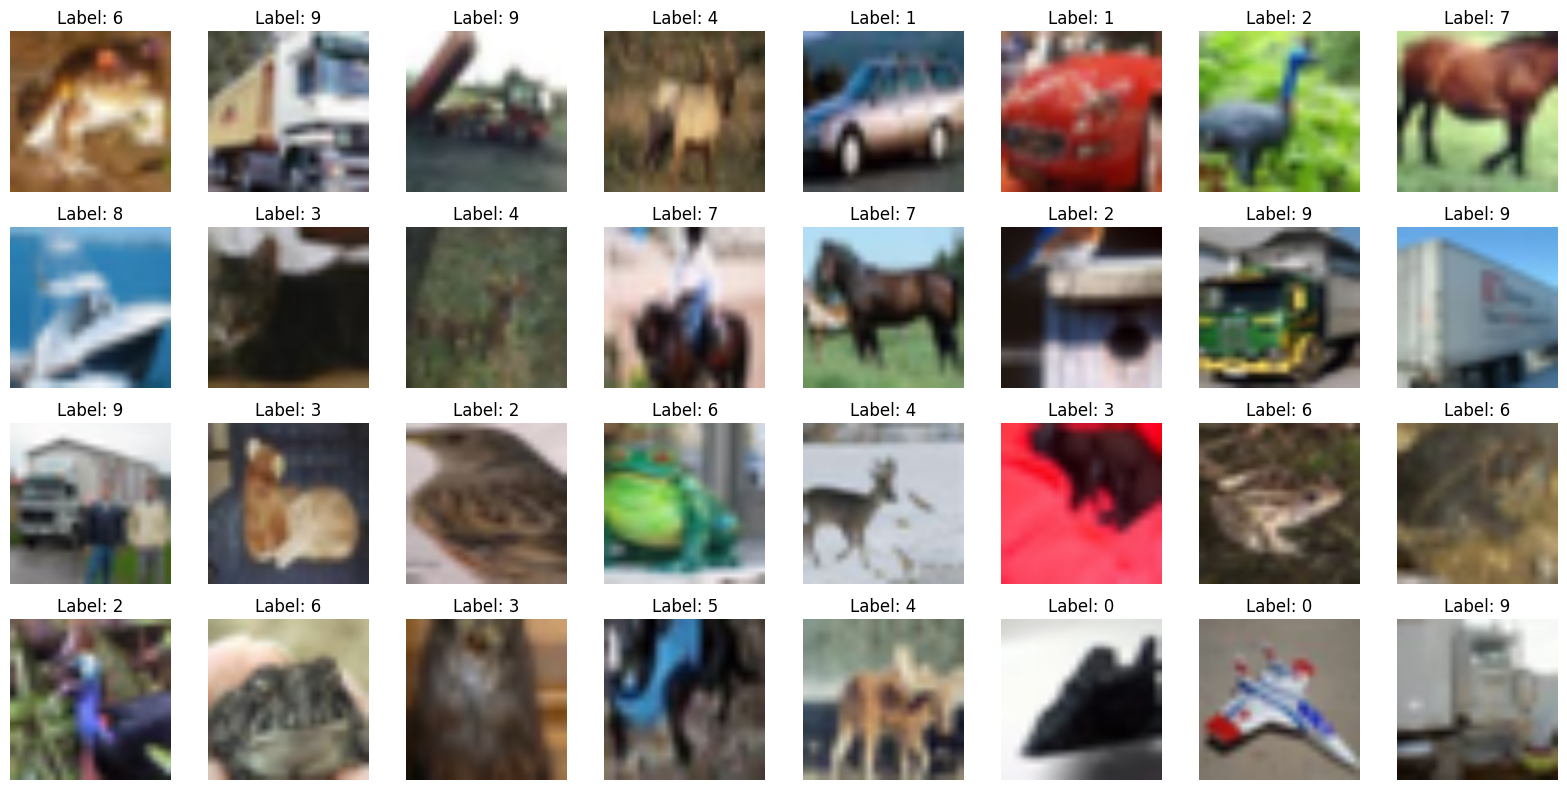

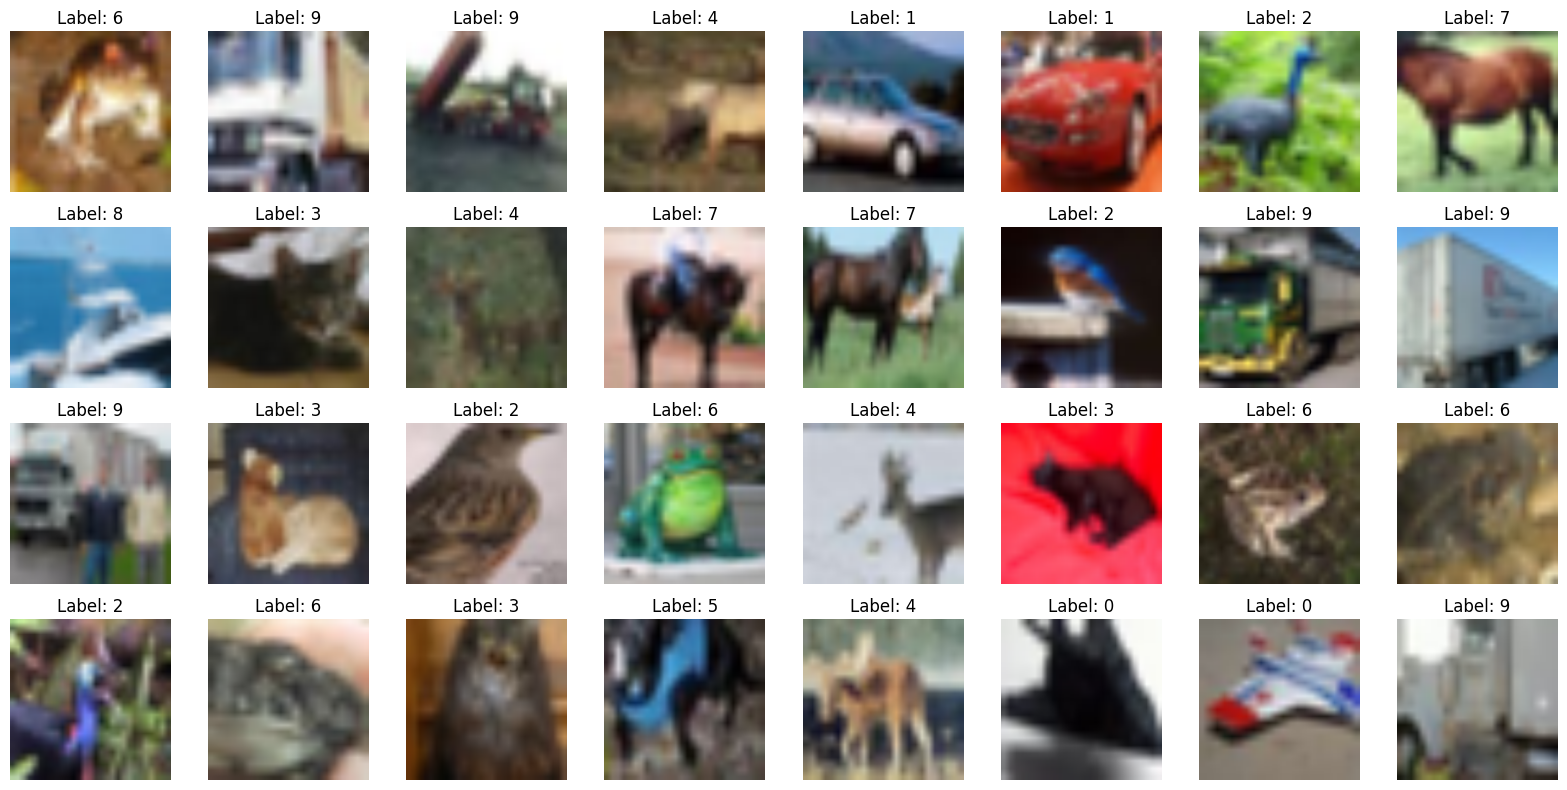

In [15]:
def imshow(images, labels, ncols=8, nrows=4):
    # TODO:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
    axes = axes.flatten()
    
    mean = torch.tensor([0.5071, 0.4867, 0.4408])
    std = torch.tensor([0.2675, 0.2565, 0.2761])

    for i in range(nrows * ncols):
        img = images[i] * std[:, None, None] + mean[:, None, None]
        img = img.numpy().transpose((1, 2, 0))
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")

    plt.tight_layout()
    plt.show()

# show some training images with shuffle=False and labels
images = []
labels = []
for i in range(32):
    img, label = train_set[i]
    images.append(img)
    labels.append(label)
images = torch.stack(images)
labels = torch.tensor(labels)

imshow(images, labels)

# show them again to check the augmentation
data_iter = iter(train_loader_half)
images, labels = next(data_iter)

imshow(images, labels)

# create train loader with shuffle true
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [16]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    losses = []
    model.train() if train_mode else model.eval()

    with torch.set_grad_enabled(train_mode):
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    return losses


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    train_losses, val_losses = [], []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.append(sum(train_loss) / len(train_loss))

        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_loss) / len(val_loss))

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_losses[-1]:.4f} - "
              f"Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.

    Returns:
        None
    """

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [17]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


In normal convolution, we have C_in * K_w * K_h * C_out parameters (excluding bias terms). In depthwise separable convolution, we have C_in * K_w * K_h + C_in * C_out parameters. As we see, number of parameters in depthwise separable convolution is less. We can implement normal convolutions by depthwise separable convolutions. As it has fewer parameters, the training and inference would be faster by reducing multiplications.

Now please create your model.

In [18]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.conv1 = conv_bn(3, 32, 2)
        self.conv2 = conv_dw(32, 64, stride=1)
        self.conv3 = conv_dw(64, 128, stride=2)
        self.conv4 = conv_dw(128, 128, stride=1)
        self.conv5 = conv_dw(128, 256, stride=2)
        self.conv6 = conv_dw(256, 256, stride=1)
        self.conv7 = conv_dw(256, 512, stride=2)
        self.conv8 = conv_dw(512, 512, stride=1)
        self.conv9 = conv_dw(512, 512, stride=1)
        self.conv10 = conv_dw(512, 512, stride=1)
        self.conv11 = conv_dw(512, 512, stride=1)
        self.conv12 = conv_dw(512, 512, stride=1)
        self.conv13 = conv_dw(512, 1024, stride=2)
        self.conv14 = conv_dw(1024, 1024, stride=1)
        self.pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(1024, n_class)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [19]:
epochs = 10
lr = 1e-3
# TODO:
mobilenet_model = MobileNet(n_class=10).to(device)
mobilenet_train_losses, mobilenet_val_losses = train(train_loader, val_loader, mobilenet_model, epochs, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 1.4515 - Validation Loss: 1.2029


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 1.0210 - Validation Loss: 0.9127


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.8057 - Validation Loss: 0.6611


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.6873 - Validation Loss: 0.6463


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.6153 - Validation Loss: 0.5668


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.5490 - Validation Loss: 0.5094


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.5032 - Validation Loss: 0.5338


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.4618 - Validation Loss: 0.4358


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.4311 - Validation Loss: 0.4529


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.4026 - Validation Loss: 0.4044


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 86.3
Process validation time: 9.9415 s


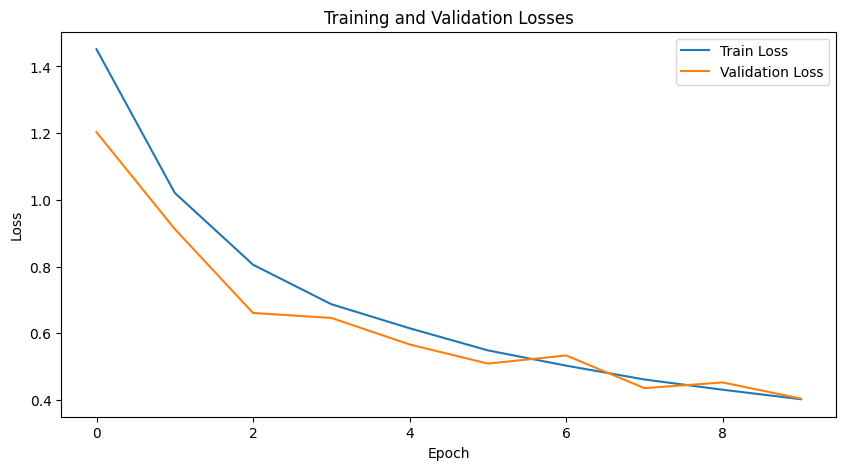

In [20]:
start = time.time()
val_acc = get_acc(mobilenet_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(mobilenet_train_losses, mobilenet_val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


In normal convolution, we have C_in * K_w * K_h * C_out * w * h FLOPs. In depthwise separable convolution, we have C_in * K_w * K_h * w * h + C_in * C_out * w * h FLOPs. Considering K_w = K_h = 3, we can simply drive that depthwise separable convolution has one ninth FLOPs. So it would be about 9 times faster.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [21]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [22]:
# TODO: train model
epochs = 2
lr = 1e-3
cnn_model = NormalCNN(n_class=10).to(device)
cnn_train_losses, cnn_val_losses = train(train_loader, val_loader, cnn_model, epochs, lr) 

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/2] - Train Loss: 1.8816 - Validation Loss: 1.7039


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/2] - Train Loss: 1.4915 - Validation Loss: 1.3703


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 50.25
Process validation time: 12.4715 s


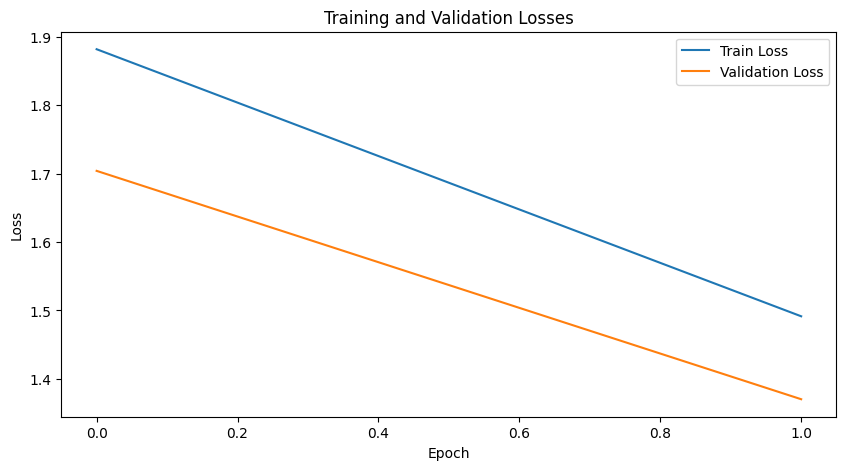

In [23]:
start = time.time()
val_acc = get_acc(cnn_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(cnn_train_losses, cnn_val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

It took 2:23 per epoch to train normal CNN, while it took 1:39 per epoch to train MobileNet. So, MobileNet is faster. MobileNet is faster in validation as well: 10s vs 12s.

In [24]:
# TODO: compare number of parameters in these two models
cnn_params = sum(p.numel() for p in cnn_model.parameters())
mobilenet_params = sum(p.numel() for p in mobilenet_model.parameters())

print(f"Number of parameters in CNN model: {cnn_params}")
print(f"Number of parameters in MobileNet model: {mobilenet_params}")

Number of parameters in CNN model: 28279338
Number of parameters in MobileNet model: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [25]:
torch.save(mobilenet_model.state_dict(), "mobilenet_cifar10.pth")
print("Pre-trained MobileNet model saved as mobilenet_cifar10.pth")

Pre-trained MobileNet model saved as mobilenet_cifar10.pth


In [26]:
model = MobileNet(n_class=100).to(device)

#Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_dict = torch.load("mobilenet_cifar10.pth")
model_dict = model.state_dict()

# Filter out unnecessary keys from the pretrained dict
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Load the updated state dict into the model
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

print("Pre-trained weights loaded into MobileNet for CIFAR-100.")

Pre-trained weights loaded into MobileNet for CIFAR-100.


<ipython-input-26-e0a8c333e5b7>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load("mobilenet_cifar10.pth")


**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [27]:
# Freeze up to the desired layer (e.g., the first 7 layers)
def freeze_layers(model, num_layers_to_freeze=7):
    layer_count = 0
    for name, param in model.named_parameters():
        if layer_count < num_layers_to_freeze:
            param.requires_grad = False
        else:
            break
        layer_count += 1

freeze_layers(model, num_layers_to_freeze=7)

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [28]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=4)

train_loader100_unshuffled = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=False, num_workers=4)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 169001437/169001437 [00:03<00:00, 49210391.20it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

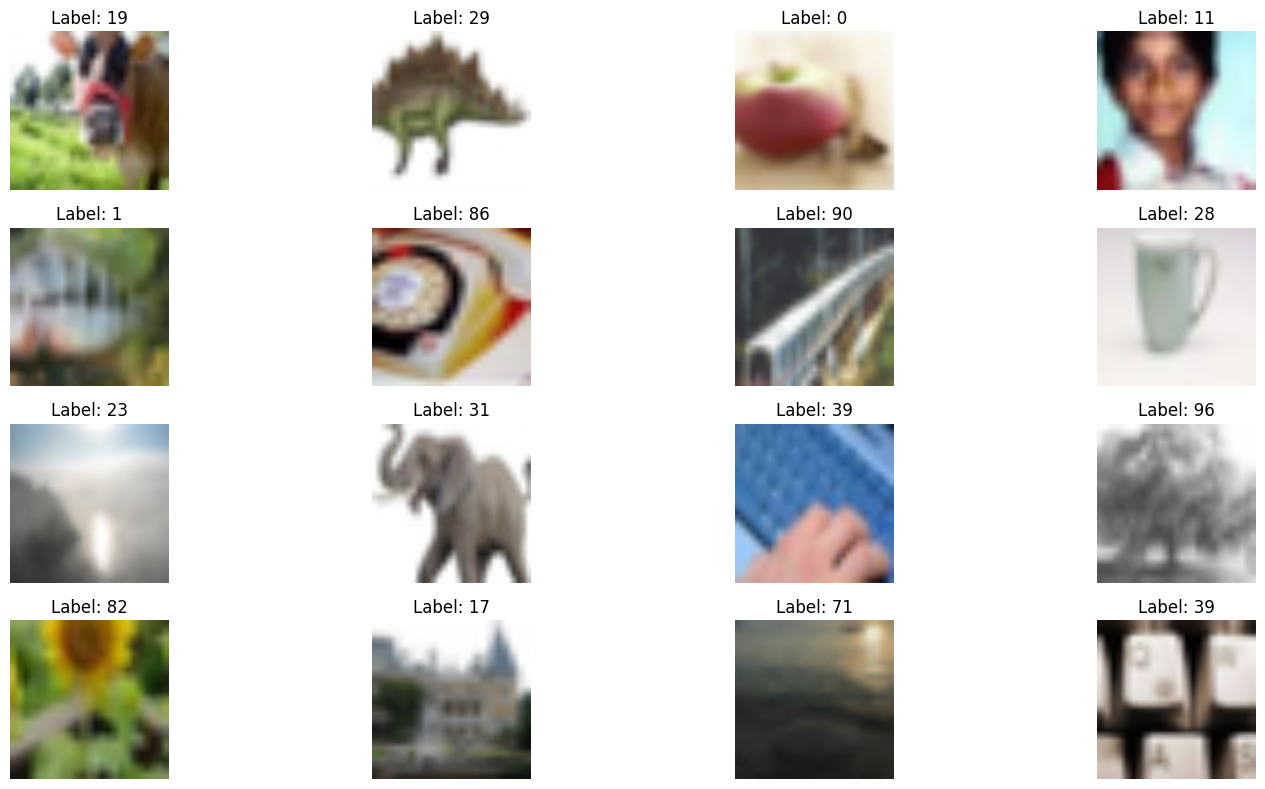

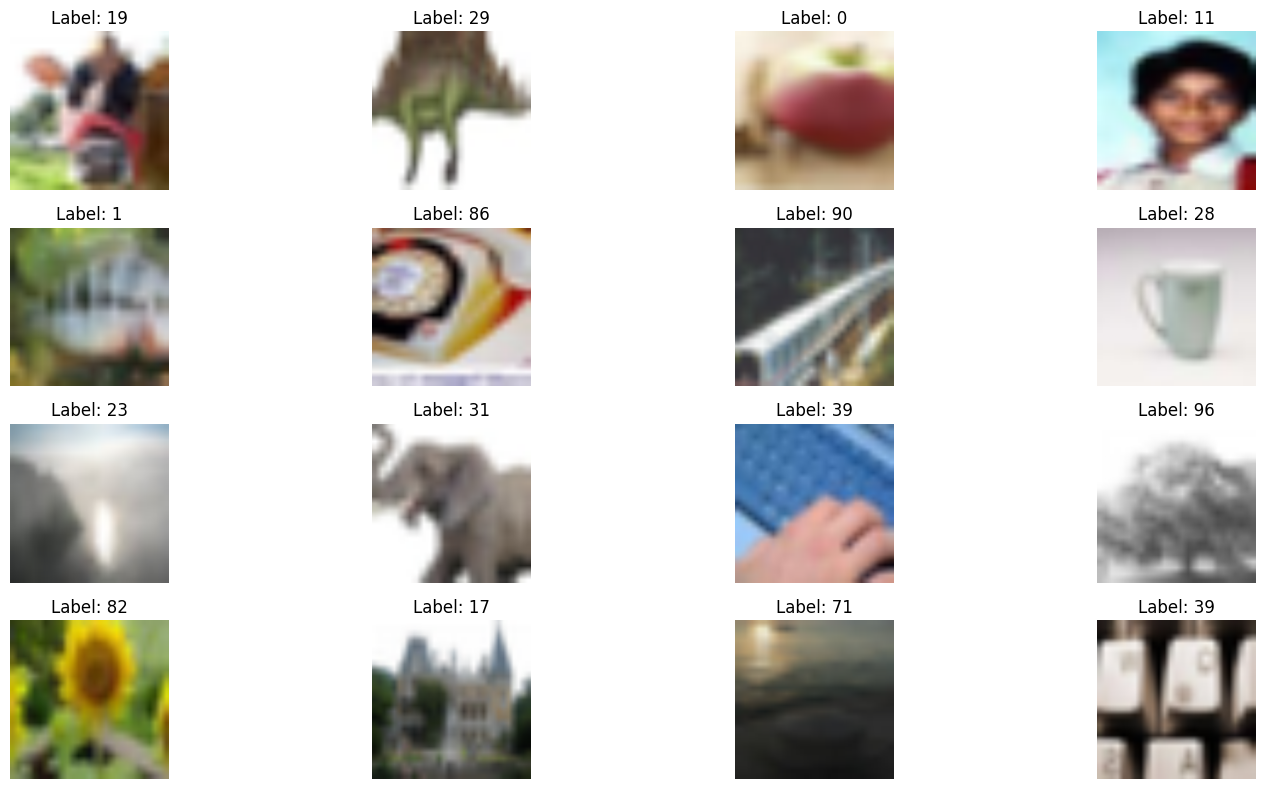

In [44]:
# show some training images with shuffle=False and labels
images = []
labels = []
for i in range(32):
    img, label = train_set100[i]
    images.append(img)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

imshow(images, labels, ncols=4)

# show them again to check the augmentation
data_iter = iter(train_loader100_unshuffled)
images, labels = next(data_iter)

imshow(images, labels, ncols=4)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

As https://www.cs.toronto.edu/~kriz/cifar.html?utm_source=chatgpt.com says, they don't share any images. The classes are disjoint as well.

Now train your model using your functions.

In [31]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/7] - Train Loss: 4.0234 - Validation Loss: 3.4134


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/7] - Train Loss: 3.1774 - Validation Loss: 2.8819


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/7] - Train Loss: 2.7742 - Validation Loss: 2.6093


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/7] - Train Loss: 2.5175 - Validation Loss: 2.4038


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/7] - Train Loss: 2.3314 - Validation Loss: 2.2541


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/7] - Train Loss: 2.1835 - Validation Loss: 2.1374


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/7] - Train Loss: 2.0507 - Validation Loss: 2.0494


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 44.36
Process validation time: 9.9454 s


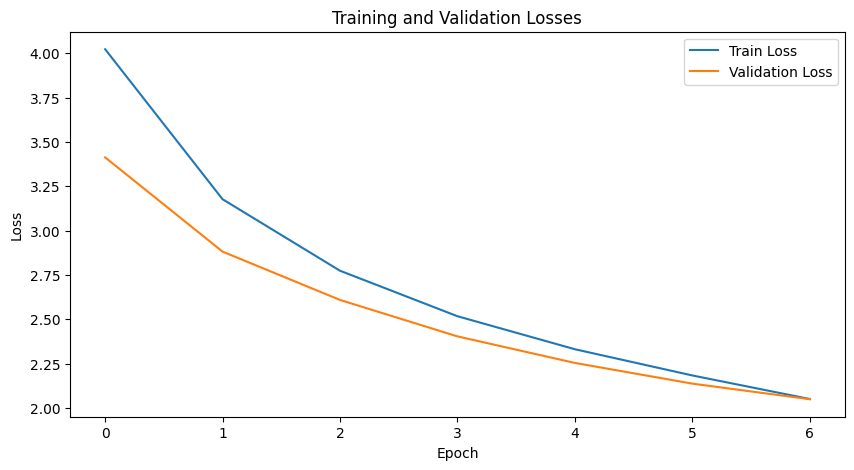

In [32]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

It it a version of ReLU: ReLU6(x) = min(max(0,x),6).
We use it to ensure that no activaion value would be very big, which slows computations. It also helps avoid numerical instablility issues in low precision hardware.

In [33]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_residual = self.stride == 1 and inp == oup
        hidden_dim = int(inp * expand_ratio)

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [34]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):

        super(MobileNetV2, self).__init__()
        
        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # building first layer
        self.features = [conv_bn(3, input_channel, stride=2)]
        
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                if i == 0:
                    self.features.append(InvertedResidual(input_channel, output_channel, s, t))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, t))
                input_channel = output_channel
    
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.features = nn.Sequential(*self.features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, n_class),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


I created them by use of linear layers in bottleneck stages, instead of ReLU. They ensure that important features are preserved during compression and expansion process, leading to the model remain accurate without too much computations.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [35]:
mobilenet_v2_model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train(train_loader, val_loader, mobilenet_v2_model, epochs, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 1.4988 - Validation Loss: 1.4087


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 1.0875 - Validation Loss: 0.9180


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.8995 - Validation Loss: 0.7508


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.7801 - Validation Loss: 0.7285


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.7019 - Validation Loss: 0.6820


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.6516 - Validation Loss: 0.6607


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.5993 - Validation Loss: 0.5931


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.5665 - Validation Loss: 0.5645


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.5337 - Validation Loss: 0.5007


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.5070 - Validation Loss: 0.4749


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 83.65
Process validation time: 10.6727 s


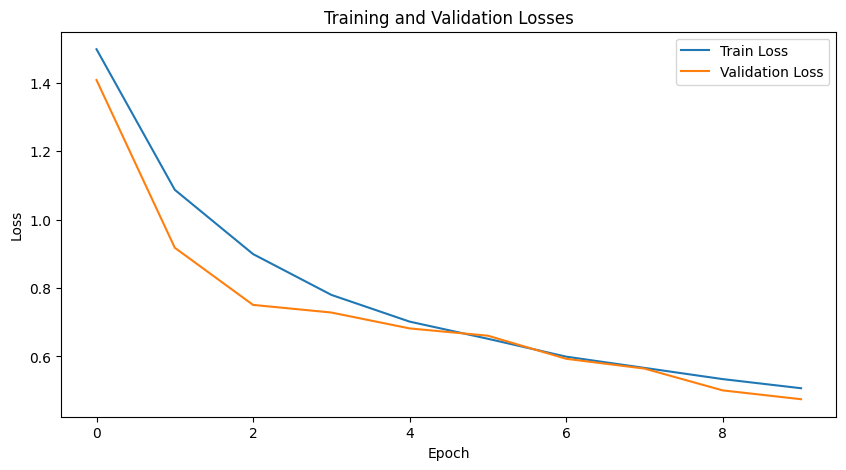

In [36]:
start = time.time()
val_acc = get_acc(mobilenet_v2_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(mobilenet_v2_train_losses, mobilenet_v2_val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [37]:
# TODO
for width_multiplier in [i / 10 for i in range(1, 11)]:
    model = MobileNetV2(n_class=10, input_size=224, width_multiplier=width_multiplier)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Width Multiplier: {width_multiplier:.1f}, Number of Parameters: {num_params}")

Width Multiplier: 0.1, Number of Parameters: 31255
Width Multiplier: 0.2, Number of Parameters: 105224
Width Multiplier: 0.3, Number of Parameters: 221676
Width Multiplier: 0.4, Number of Parameters: 380438
Width Multiplier: 0.5, Number of Parameters: 587178
Width Multiplier: 0.6, Number of Parameters: 826943
Width Multiplier: 0.7, Number of Parameters: 1113168
Width Multiplier: 0.8, Number of Parameters: 1441788
Width Multiplier: 0.9, Number of Parameters: 1812806
Width Multiplier: 1.0, Number of Parameters: 2236682


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [38]:
MNv2_path = '/kaggle/input/model/other/default/1/MNv2WMmodel.pt'
# TODO
file_dict = torch.load(MNv2_path)
pretrained_model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
pretrained_model_dict = pretrained_model.state_dict()
for key1, key2 in zip(pretrained_model_dict.keys(), file_dict.keys()):
    pretrained_model_dict[key1] = file_dict[key2]
pretrained_model.load_state_dict(pretrained_model_dict)
pretrained_model.eval()

print("Pretrained model loaded and updated successfully!")

<ipython-input-38-b2868a724fc4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file_dict = torch.load(MNv2_path)


Pretrained model loaded and updated successfully!


In [39]:
start = time.time()
val_acc = get_acc(pretrained_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 74.32
Process validation time: 9.3516 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

It multiplies standard convolution layers' and pointwise layers' parameter count by alpha^2 and depthwise layers' parameter count by alpha.
Total parameters = alpha^2(P_standard + P_pointwise) + alpha(P_depthwise + P_fullyconnected), where P_standard is count of parameters of standard convolution layers in the model with alpha=1 and so on. It's not exact because of roundings.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

It makes the model faster because number of FLOPs is proportional to w and h which are reduced. But it doesn't reduce the number of parameters because parameters are determined by the filter sizes and the number of channels in the convolutional layers. These are independent of the input resolution. 

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

Because it also increases inference time, overfitting risk, memory usage. Specifically a model like mobilenet is designed to use on mobile devices and so on that have limited resources.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [40]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [41]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 11.02
Process validation time: 11.5038 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [42]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
        student_ce_loss = self.ce_loss(student_logits, labels)

        student_log_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (self.temperature ** 2)

        loss = self.alpha * distillation_loss + (1 - self.alpha) * student_ce_loss
        return loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        
        total_loss = 0.0
        for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            student_logits = student(inputs)
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            loss = criterion(student_logits, teacher_logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

Train it for one epoch to just check if it works.

In [43]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

0it [00:00, ?it/s]

What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?

If the purpose is to align closely with the teacher’s learned features, a we use higher alpha. If the purpose is to maximize the student’s performance on the target task and improve its ability to generalize, we use lower alpha.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018